## Data loading

First we need to load the MNIST dataset from disk. We will do 10-class classification for digit 0, 1, .., 9 from the MNIST dataset here.

c:\Users\Lenovo\.conda\envs\tensor\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
c:\Users\Lenovo\.conda\envs\tensor\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


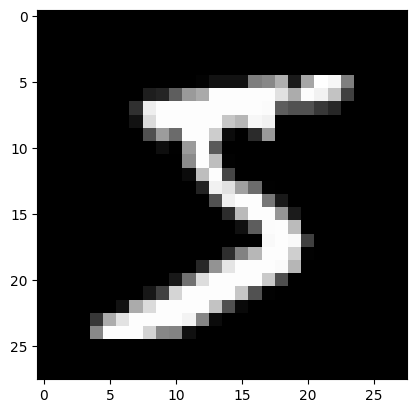

Train data shape:  (60000, 28, 28)
Train labels shape:  (60000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import edf
import mnist_loader

train_images, train_labels = mnist_loader.load_mnist(section = 'training', path = 'MNIST')
test_images, test_labels = mnist_loader.load_mnist(section = 'testing', path = 'MNIST')

plt.imshow(train_images[0], cmap='gray', interpolation = 'nearest')
plt.show()

# quickly check the shape of data
print('Train data shape: ', train_images.shape)
print('Train labels shape: ', train_labels.shape)
print('Test data shape: ', test_images.shape)
print('Test labels shape: ', test_labels.shape)


In [2]:
"""Preprocessing: we reshape the 28x28 grayscale MNIST images to 
784-dimensional vectors, which will be the network's inputs"""

train_images = train_images.reshape(len(train_images), -1)
test_images = test_images.reshape(len(test_images), -1)

# now check the shape of data after reshaping
print('Train data shape: ', train_images.shape)
print('Train labels shape: ', train_labels.shape)
print('Test data shape: ', test_images.shape)
print('Test labels shape: ', test_labels.shape)

Train data shape:  (60000, 784)
Train labels shape:  (60000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)


## Logistic Regression for 10-Class Image Classification

Use EDF to assemble a computational graph for logistic regression with the softmax function. You can reuse your code from excercise 1, but no need to use `SingleProbToProbVector` class anymore because we are now tackling image classification task on **10** different classes, instead of 2 classes. Moreover, please replace the output function that you used before from `Sigmoid` to `Softmax`.

Note that we don't need to implment the backward pass because the backward function of `Affine`, `Sigmoid` and `Softmax` have been implemented in EDF.

In [ ]:
nInputs = train_images.shape[1] # 784-dimension 
nOutputs = 10 # Output dimension

edf.clear_compgraph()

# TO-DO: Define the computation graph here
x_node = edf.Input()
y_node = edf.Input()

affine_params  = edf.AffineParams(nInputs, nOutputs) 
affine_node = edf.Affine(affine_params , x_node)

prob_node = edf.Softmax(affine_node)#/.??
loss_node = edf.CrossEntropyLoss(prob_node, y_node)

In [4]:
"""the following functions are used to train the network.
training is done by iterating over mini-batches of size 'batch_size'
and updating the model's parameters with SGD"""

def run_epoch(batch_size, data, labels, x_node, y_node, prob_node, loss_node=None):
    num_samples = len(data)
    total_err = 0.0
    num_batches = num_samples//batch_size
    for i in range(num_batches):
        start, end = i*batch_size, (i+1)*batch_size
        x_node.value = train_images[start:end]
        y_node.value = train_labels[start:end]
        edf.Forward()
        total_err += np.sum(np.not_equal(np.argmax(prob_node.value, axis=1), y_node.value))
        if loss_node:
            edf.Backward(loss_node)
            edf.UpdateParameters()
        if i>0 and i%400 == 0:
            print ("\t Batch {}/{}".format(i, num_batches))
    return 100*total_err/num_samples

def train_and_test(num_epochs, batch_size, x_node, y_node, prob_node, loss_node):
    train_err_log = []
    test_err_log = []
    for epoch in range(num_epochs):
        print("Epoch: {}/{} (learning rate: {})".format(epoch+1, num_epochs, edf.learning_rate))
        train_err = run_epoch(batch_size, train_images, train_labels, x_node, y_node, prob_node, loss_node)
        train_err_log.append(train_err)
        print ("\t Training Error {:.2f} %".format(train_err))
        test_err = run_epoch(len(test_images), test_images, test_labels, x_node, y_node, prob_node)
        test_err_log.append(test_err)
        print ("\t Test Error {:.2f} %".format(test_err))
    return train_err_log, test_err_log

"""plot function"""
def plot(train_err_log, test_err_log):
    plt.xlabel("epochs")
    plt.ylabel("error (%)")
    plt.plot(np.arange(len(test_err_log)), test_err_log, color='red')
    plt.plot(np.arange(len(train_err_log)), train_err_log, color='blue')
    plt.legend(['test error', 'train error'], loc='upper right')
    plt.show()
    plt.clf()

Epoch: 1/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 10.60 %
	 Test Error 9.81 %
Epoch: 2/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 8.44 %
	 Test Error 9.23 %
Epoch: 3/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 8.04 %
	 Test Error 8.81 %
Epoch: 4/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 7.87 %
	 Test Error 8.73 %
Epoch: 5/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 7.74 %
	 Test Error 8.52 %
Epoch: 6/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 7.65 %
	 Test Error 8.35 %
Epoch: 7/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 7.58 %
	 Test Error 8.26 %
Epoch: 8/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 7.53 %
	 Test Error 8.19 %
Epoch: 9/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 7.46 %
	 Test Error 8.14 %
Epoch: 10/10 (lear

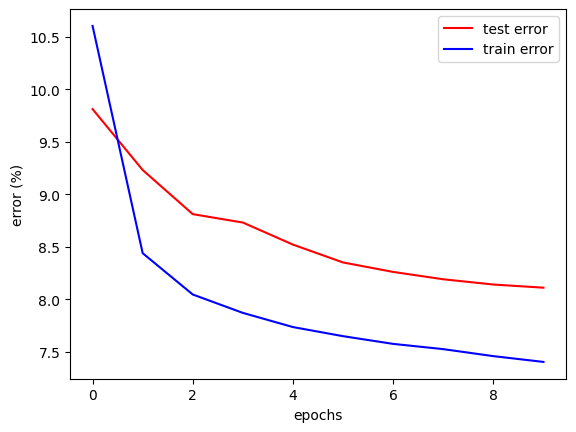

<Figure size 640x480 with 0 Axes>

In [5]:
"""now, we are ready to train the logistic regression. we can choose SGD's learning rate
by changing edf.learning_rate, which we will set as 0.5 for now."""

num_epochs = 10
batch_size = 64
edf.learning_rate = 0.5
train_err_log, test_err_log = train_and_test(num_epochs, batch_size, x_node, y_node, prob_node, loss_node)
plot(train_err_log, test_err_log)

### Inline Question 1:
If your logistic regression model weight is randomly initalized, and no training is done as above. What test error do you think the model will get?

**Your answer:** *50%*


## MNIST Image Classification with MLP 

You may notice that the logistic regression model resulted with relatively high errors (~8%). Now it is time to see the power of neural network :)  

You now should develop a multi-layer perceptron with two layers.
Use EDF to assemble a computational graph for image classification using MLP with the vectorized images as input. Similar to the logistic regression task, the function `train_and_test` below expects variables `x_node`, `y_node`, `prob_node` and `loss_node` to be defined. `prob_node` calculates the class probabilities for each training sample, while we use `CrossEntropyLoss` for the `loss_node` to calculate the loss for the entire training batch. `Softmax` should be also used for the output.

In [8]:
nInputs = train_images.shape[1] # 784-dimension 
nOutputs = 10 # Output dimension
nHiddens = 64 # Number of neurons in the hidden layer

edf.clear_compgraph()

# TO-DO: Define the computation graph here
x_node = edf.Input()
y_node = edf.Input()


affine_params  = edf.AffineParams(nInputs, nHiddens)
affine_node = edf.Affine(affine_params , x_node)
softmax_node = edf.Softmax(affine_node)

output_params = edf.AffineParams(nHiddens, nOutputs)
output_node = edf.Affine(output_params, softmax_node)

prob_node = edf.Softmax(output_node)
loss_node = edf.CrossEntropyLoss(prob_node, y_node)

Epoch: 1/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 62.45 %
	 Test Error 56.24 %
Epoch: 2/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 57.31 %
	 Test Error 56.55 %
Epoch: 3/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 56.40 %
	 Test Error 55.82 %
Epoch: 4/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 55.62 %
	 Test Error 56.05 %
Epoch: 5/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 54.01 %
	 Test Error 53.57 %
Epoch: 6/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 48.68 %
	 Test Error 49.02 %
Epoch: 7/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 40.89 %
	 Test Error 32.52 %
Epoch: 8/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 31.76 %
	 Test Error 31.07 %
Epoch: 9/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 30.18 %
	 Test Error 28.29 %
E

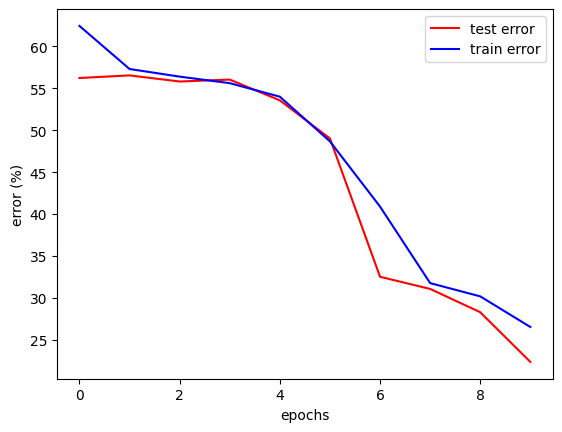

<Figure size 640x480 with 0 Axes>

In [9]:
"""now, we are ready to train the network. we can choose SGD's learning rate
by changing edf.learning_rate, which we will set as 0.5 for now."""

num_epochs = 10
batch_size = 64
edf.learning_rate = 0.5
train_err_log, test_err_log = train_and_test(num_epochs, batch_size, x_node, y_node, prob_node, loss_node)
plot(train_err_log, test_err_log)

# Architecture Choice

## Activation functions
We want to explore the performance when using different activation function.

First, you will implement a `Tanh` activation function by filling the missing
code in the `forward` and `backward` methods below. You can re-use parts of EDF's Sigmoid code.


In [28]:
class Tanh(edf.CompNode):
    def __init__(self, x):
        edf.CompNodes.append(self)
        self.x = x

    def forward(self):
        # To-DO: implement the forward pass
        self.value = np.tanh(self.x.value)

    def backward(self):
        # 计算 Tanh 的导数并乘以上层传递的梯度
        self.x.addgrad((1.0 - np.tanh(self.x.value) ** 2) * self.grad)


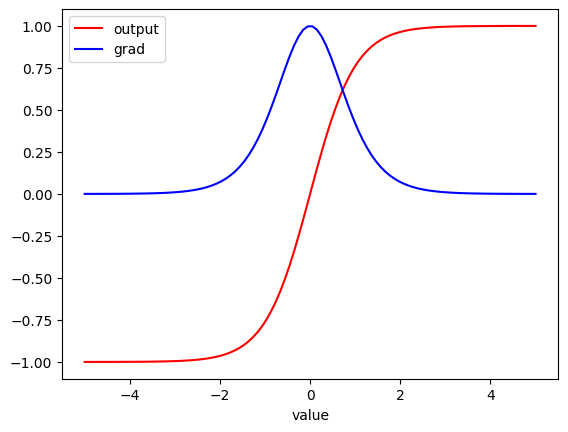

<Figure size 640x480 with 0 Axes>

In [29]:
"""the code below will plot the output and gradients computed by your
implementation of the Tanh component above. check if the plots match
Tanh(x) and dTanh/dx(x) as a sanity test of your implementation."""

values = np.linspace(-5,5,100)
edf.clear_compgraph()
params = edf.Parameter(values[None, :])
output = Tanh(params)

edf.Forward()
edf.Backward(output)

plt.xlabel("value")
plt.plot(values, output.value[0], color='red')
plt.plot(values, params.grad[0], color='blue')
plt.legend(['output', 'grad'], loc='upper left')
plt.show()
plt.clf()

Again, assemble a computational graph for image classification using MLP with `Tanh` activation function. The function `train_and_test` below expects variables `x_node`, `y_node`, `prob_node` and `loss_node` to be defined.

In [45]:
nInputs = train_images.shape[1] # 784-dimension 
nOutputs = 10 # Output dimension
nHiddens = 64 # Number of neurons in the hidden layer

np.random.seed(1234)
edf.clear_compgraph()

# TO-DO: Define the computation graph here
x_node = edf.Input()
y_node = edf.Input()


affine_params  = edf.AffineParams(nInputs, nHiddens)
affine_node = edf.Affine(affine_params , x_node)
softmax_node = Tanh(affine_node)

output_params = edf.AffineParams(nHiddens, nOutputs)
output_node = edf.Affine(output_params, softmax_node)

prob_node = edf.Softmax(output_node)
loss_node = edf.CrossEntropyLoss(prob_node, y_node)

Epoch: 1/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 8.29 %
	 Test Error 6.01 %
Epoch: 2/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.21 %
	 Test Error 4.13 %
Epoch: 3/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.05 %
	 Test Error 2.93 %
Epoch: 4/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.38 %
	 Test Error 2.26 %
Epoch: 5/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.95 %
	 Test Error 1.82 %
Epoch: 6/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.60 %
	 Test Error 1.60 %
Epoch: 7/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.31 %
	 Test Error 1.41 %
Epoch: 8/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.07 %
	 Test Error 1.28 %
Epoch: 9/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 0.84 %
	 Test Error 1.20 %
Epoch: 10/10 (learn

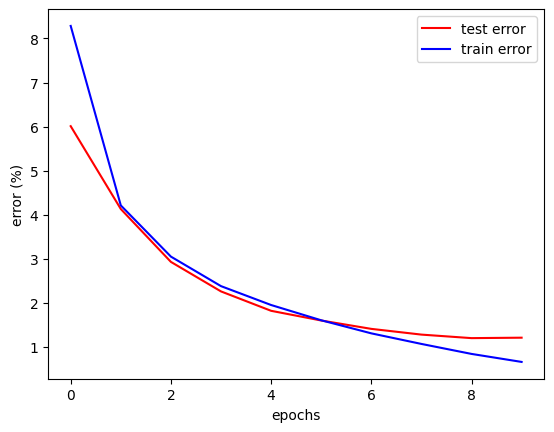

<Figure size 640x480 with 0 Axes>

In [46]:
"""now, we are ready to train the Tanh MLP network. """

num_epochs = 10
batch_size = 64
edf.learning_rate = 0.5
train_err_log, test_err_log = train_and_test(num_epochs, batch_size, x_node, y_node, prob_node, loss_node)
plot(train_err_log, test_err_log)

Now, you will implement a ReLU activation function ReLU(x) = max(0,x).
implement the `forward` and `backward` methods of the following class.


In [32]:
class ReLU(edf.CompNode):
    def __init__(self, x):
        edf.CompNodes.append(self)
        self.x = x

    def forward(self):
        # 计算前向传播：ReLU 激活函数
        self.value = np.maximum(0, self.x.value)

    def backward(self):
        # 计算反向传播：根据前向计算值判断梯度
        # ReLU 对于正值部分的导数为 1，对于负值或零的部分为 0
        relu_grad = (self.x.value > 0).astype(float)
        self.x.addgrad(self.grad * relu_grad)



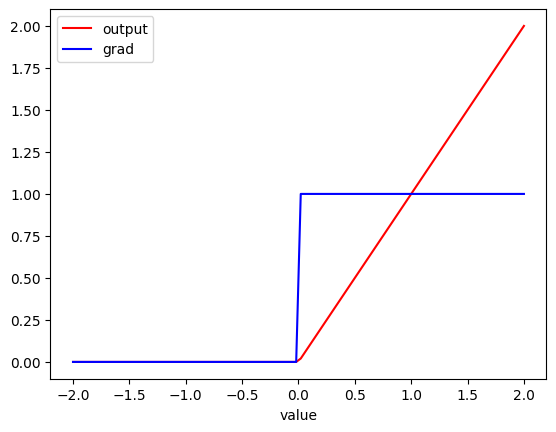

<Figure size 640x480 with 0 Axes>

In [33]:
"""the code below will plot the output and gradients computed by your
implementation of the ReLU component above. check if the plots match
ReLU(x) and dReLU/dx(x) as a sanity test of your implementation."""

values = np.linspace(-2,2,100)
edf.clear_compgraph()
params = edf.Parameter(values[None, :])
output = ReLU(params)

edf.Forward()
edf.Backward(output)

plt.xlabel("value")
plt.plot(values, output.value[0], color='red')
plt.plot(values, params.grad[0], color='blue')
plt.legend(['output', 'grad'], loc='upper left')
plt.show()
plt.clf()

Again, assemble a computational graph for image classification using MLP with `ReLU` activation function. The function `train_and_test` below expects variables `x_node`, `y_node`, `prob_node` and `loss_node` to be defined.

In [43]:
nInputs = train_images.shape[1] # 784-dimension 
nOutputs = 10 # Output dimension
nHiddens = 64 # Number of neurons in the hidden layer

np.random.seed(1234)
edf.clear_compgraph()

# TO-DO: Define the computation graph here
x_node = edf.Input()
y_node = edf.Input()


affine_params  = edf.AffineParams(nInputs, nHiddens)
affine_node = edf.Affine(affine_params , x_node)
softmax_node = ReLU(affine_node)

output_params = edf.AffineParams(nHiddens, nOutputs)
output_node = edf.Affine(output_params, softmax_node)

prob_node = edf.Softmax(output_node)
loss_node = edf.CrossEntropyLoss(prob_node, y_node)

Epoch: 1/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 7.99 %
	 Test Error 6.50 %
Epoch: 2/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.70 %
	 Test Error 4.08 %
Epoch: 3/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.72 %
	 Test Error 2.79 %
Epoch: 4/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.16 %
	 Test Error 2.49 %
Epoch: 5/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.79 %
	 Test Error 2.12 %
Epoch: 6/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.50 %
	 Test Error 2.00 %
Epoch: 7/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.36 %
	 Test Error 2.20 %
Epoch: 8/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.10 %
	 Test Error 1.88 %
Epoch: 9/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.02 %
	 Test Error 1.55 %
Epoch: 10/10 (learn

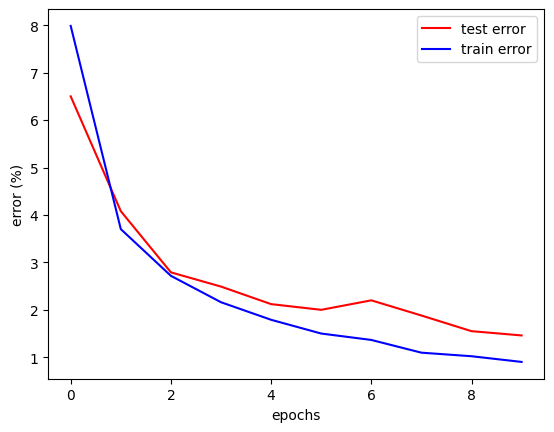

<Figure size 640x480 with 0 Axes>

In [44]:

"""now, we are ready to train the ReLU MLP network. """

num_epochs = 10
batch_size = 64
edf.learning_rate = 0.5
train_err_log, test_err_log = train_and_test(num_epochs, batch_size, x_node, y_node, prob_node, loss_node)
plot(train_err_log, test_err_log)

Now, you will implement a LeakyReLU(x) = max(cx, x) with the constant `c` = 0.01.
implement the `forward` and `backward` methods of the following class.


In [36]:
class LeakyReLU(edf.CompNode):
    def __init__(self, x, c=0.01):
        edf.CompNodes.append(self)
        self.x = x
        self.c = c  # 常数 c，用于负值部分的斜率

    def forward(self):
        # 计算前向传播：LeakyReLU 激活函数
        self.value = np.where(self.x.value > 0, self.x.value, self.c * self.x.value)

    def backward(self):
        # 计算反向传播：根据前向计算值判断梯度
        leaky_relu_grad = np.where(self.x.value > 0, 1, self.c)
        # 传递梯度
        self.x.addgrad(self.grad * leaky_relu_grad)


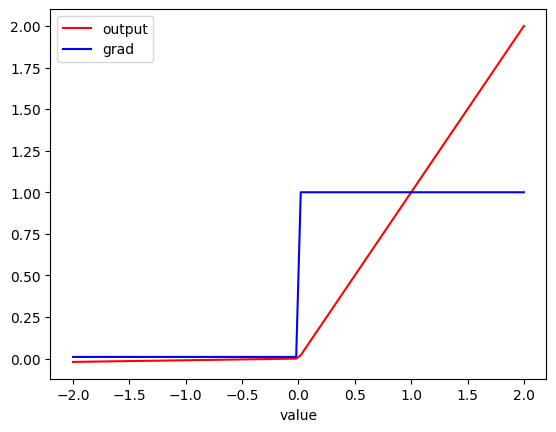

<Figure size 640x480 with 0 Axes>

In [37]:
"""the code below will plot the output and gradients computed by your
implementation of the ReLU component above. check if the plots match
LeakyReLU(x) and d LeakyReLU/dx(x) as a sanity test of your implementation."""

values = np.linspace(-2,2,100)
edf.clear_compgraph()
params = edf.Parameter(values[None, :])
output = LeakyReLU(params)

edf.Forward()
edf.Backward(output)

plt.xlabel("value")
plt.plot(values, output.value[0], color='red')
plt.plot(values, params.grad[0], color='blue')
plt.legend(['output', 'grad'], loc='upper left')
plt.show()
plt.clf()

Again, assemble a computational graph for image classification using MLP with `LeakyReLU` activation function. The function `train_and_test` below expects variables `x_node`, `y_node`, `prob_node` and `loss_node` to be defined.

In [38]:
nInputs = train_images.shape[1] # 784-dimension 
nOutputs = 10 # Output dimension
nHiddens = 64 # Number of neurons in the hidden layer

np.random.seed(1234)
edf.clear_compgraph()

# TO-DO: Define the computation graph here
# 输入节点
x_node = edf.Input()  # 输入图像数据
y_node = edf.Input()  # 输入标签数据

# 隐藏层的 Affine 操作
affine_params_hidden = edf.AffineParams(nInputs, nHiddens)  # 输入到隐藏层的权重和偏置参数
affine_hidden_node = edf.Affine(affine_params_hidden, x_node)  # 输入 x_node 通过线性变换到隐藏层
activation_hidden = LeakyReLU(affine_hidden_node)  # 使用 LeakyReLU 作为隐藏层的激活函数

# 输出层的 Affine 操作
affine_params_output = edf.AffineParams(nHiddens, nOutputs)  # 隐藏层到输出层的权重和偏置参数
affine_output_node = edf.Affine(affine_params_output, activation_hidden)  # 隐藏层输出通过线性变换到输出层

# 使用 Softmax 将输出层的结果转换为概率
prob_node = edf.Softmax(affine_output_node)

# 计算交叉熵损失
loss_node = edf.CrossEntropyLoss(prob_node, y_node)

Epoch: 1/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 7.99 %
	 Test Error 6.37 %
Epoch: 2/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.67 %
	 Test Error 3.83 %
Epoch: 3/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.73 %
	 Test Error 3.00 %
Epoch: 4/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.26 %
	 Test Error 2.65 %
Epoch: 5/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.93 %
	 Test Error 2.59 %
Epoch: 6/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.59 %
	 Test Error 2.36 %
Epoch: 7/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.39 %
	 Test Error 2.10 %
Epoch: 8/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.25 %
	 Test Error 2.47 %
Epoch: 9/10 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.12 %
	 Test Error 1.64 %
Epoch: 10/10 (learn

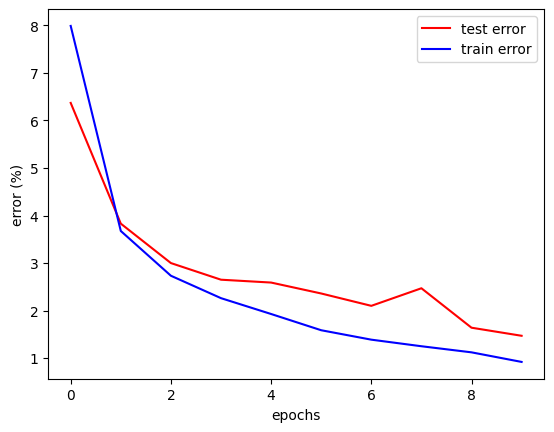

<Figure size 640x480 with 0 Axes>

In [39]:
"""now, we are ready to train the ReLU MLP network. """
num_epochs = 10
batch_size = 64
edf.learning_rate = 0.5
train_err_log, test_err_log = train_and_test(num_epochs, batch_size, x_node, y_node, prob_node, loss_node)
plot(train_err_log, test_err_log)

### Numerical Differentiation
Please implement the **symmetric difference quotient**. You can check lecture 4 slides about Numerical Differentiation.

In [56]:
def numerical_differentiation(f, x):
    """
    f: activation function
    x: input
    """
    h = 1e-4
    analytical_grad = x.grad
    
    # To-Do: calculate the numeric gradient of the function f
    # Hint: define two edf.Input(), one with value of x.value + h, and the other x.value - h
    # ...
    # ...
    # numeric_grad = ...
    x1 = edf.Input()
    x2 = edf.Input()
    x1.value = x.value + h
    x2.value = x.value - h

    f1 = f(x1)
    f2 = f(x2)
    edf.Forward()

    numeric_grad = (f1.value - f2.value) / (2 * h)
    
    max_error = np.abs(analytical_grad - numeric_grad).max()
    mean_error = np.abs(analytical_grad - numeric_grad).mean()
    
    return numeric_grad, max_error, mean_error


Now use the code below to show the difference between the analytical and numerical gradient.
Firstly, we test on the `Sigmoid` function.

Note that, if your `numerical_differentiation` is implemented correctly, you should see the analytical gradient and numeric gradient overlap.

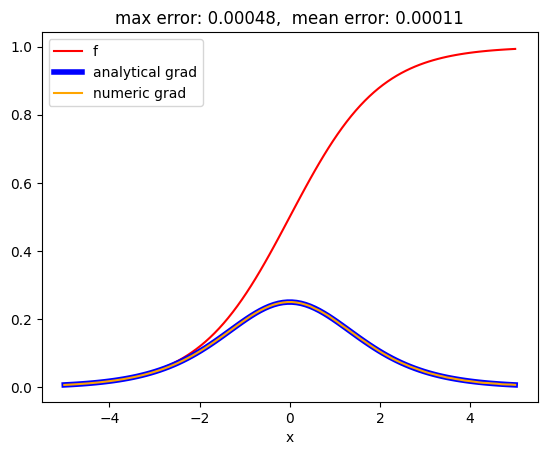

<Figure size 640x480 with 0 Axes>

In [57]:
f = edf.Sigmoid

def plot_gradient_difference(f):
    values = np.linspace(-5,5,100)
    edf.clear_compgraph()
    x = edf.Parameter(values[None, :])
    output = f(x)
    edf.Forward()
    edf.Backward(output)

    # calculate numeric gradient
    numeric_grad, max_error, mean_error = numerical_differentiation(f, x)

    plt.xlabel("x")
    plt.plot(values, output.value[0], color='red')
    plt.plot(values, x.grad[0], color='blue', linewidth=4)
    plt.plot(values, numeric_grad[0], color='orange')
    plt.legend(['f', 'analytical grad', 'numeric grad'], loc='upper left')
    plt.title('max error: %.5f,  mean error: %.5f'%(max_error, mean_error))
    plt.show()
    plt.clf()

plot_gradient_difference(f)

Now we visualize the gradients for `Tanh`, `ReLU` and `LeakyReLU`.

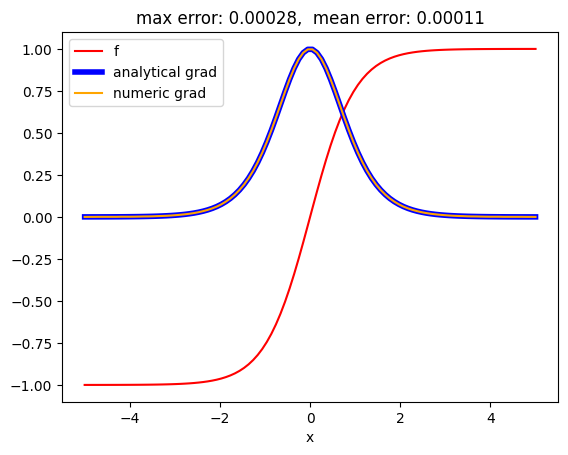

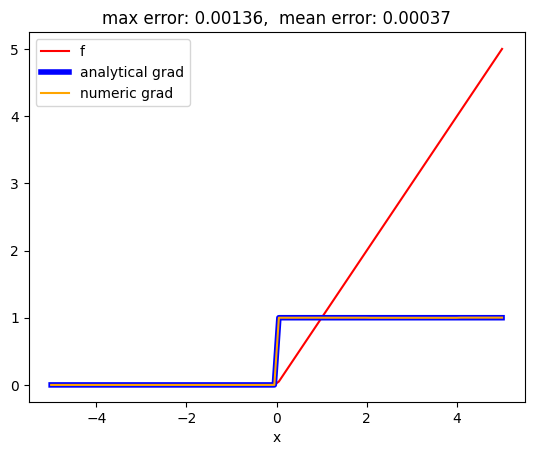

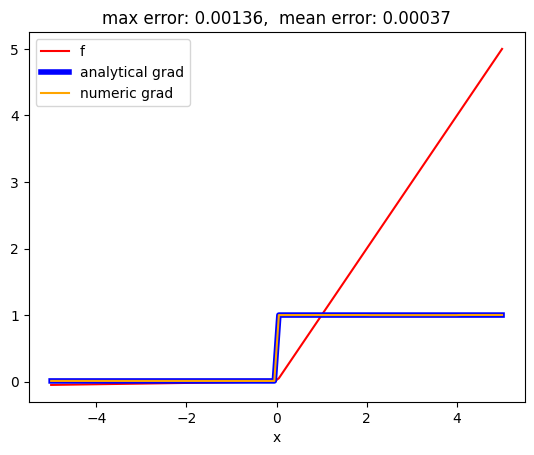

<Figure size 640x480 with 0 Axes>

In [58]:
plot_gradient_difference(Tanh)
plot_gradient_difference(ReLU)
plot_gradient_difference(LeakyReLU)

## Change Learning Rate
Let's check how changing the learning rate affects the model's train and test error. You should implement in a way to collect the network's final train/test errors for each of the learning rates in the array below. you should do this for MLPs with sigmoid and relu activations, and select the best learning rate for each of the two networks (w/ sigmoid and w/ relu activations)

Add code below to train MLPs with sigmoid activation. Your code should populate the arrays `train_err_per_lr` and `test_err_per_lr`, such that they contain the train and test errors of models trained with each learning rate in the learning_rates arrays, i.e. `train_err_per_lr[1]` should contain
the final train error of a sigmoid MLP trained with a learning
rate of 1.0.

Hint: you should be able to reuse most of the code above.

In [ ]:
num_epochs = 5
batch_size = 64
learning_rates = [0.1, 0.5, 1.0]
nInputs = train_images.shape[1]  # 784-dimension
nOutputs = 10  # Output dimension
nHiddens = 64  # Number of neurons in the hidden layer

train_err_per_lr = []
test_err_per_lr = []

for i in range(len(learning_rates)):
    edf.learning_rate = learning_rates[i]
    np.random.seed(1234)
    edf.clear_compgraph()

    # TO-DO: add training code below
    x_node = edf.Input()
    y_node = edf.Input()
    affine_hidden_node = edf.Affine(edf.AffineParams(nInputs, nHiddens), x_node)
    activation_hidden = edf.Sigmoid(affine_hidden_node)
    affine_output_node = edf.Affine(edf.AffineParams(nHiddens, nOutputs), activation_hidden)
    prob_node = edf.Softmax(affine_output_node)
    loss_node = edf.CrossEntropyLoss(prob_node, y_node)
    # 调用 train_and_test 函数进行训练和测试
    train_err_log, test_err_log = train_and_test(num_epochs, batch_size, x_node, y_node, prob_node, loss_node)

    # 将每次训练的结果保存下来
    train_err_per_lr.append(train_err_log)
    test_err_per_lr.append(test_err_log)
    #选取train_err_per_lr和test_err_per_lr中的每一列的最小值
train_err_per_lr = np.min(train_err_per_lr, axis=1)
test_err_per_lr = np.min(test_err_per_lr, axis=1)
best_sigmoid_idx = np.argmin(test_err_per_lr)
best_sigmoid_lr = learning_rates[best_sigmoid_idx]

Epoch: 1/5 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training Error 18.05 %
	 Test Error 11.01 %
Epoch: 2/5 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training Error 9.90 %
	 Test Error 9.09 %
Epoch: 3/5 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training Error 8.65 %
	 Test Error 7.99 %
Epoch: 4/5 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training Error 7.83 %
	 Test Error 7.26 %
Epoch: 5/5 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training Error 7.27 %
	 Test Error 6.65 %
Epoch: 1/5 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 11.51 %
	 Test Error 7.89 %
Epoch: 2/5 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 6.37 %
	 Test Error 5.77 %
Epoch: 3/5 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 5.00 %
	 Test Error 4.56 %
Epoch: 4/5 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.10 %
	 Test Error 3.78 %
Epoch: 5/5 (learning rate

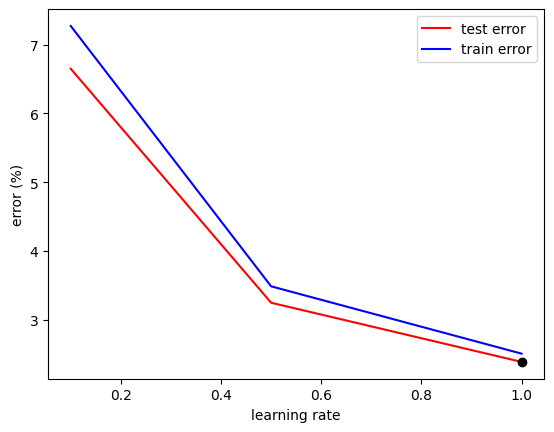

<Figure size 640x480 with 0 Axes>

In [89]:
plt.xlabel("learning rate")
plt.ylabel("error (%)")
plt.plot(learning_rates, test_err_per_lr, color='red')
plt.plot(best_sigmoid_lr, test_err_per_lr[best_sigmoid_idx], 'ok', label='_nolegend_')
plt.plot(learning_rates, train_err_per_lr, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

Now repeat the experiments above but with a `ReLU` activation function in the hidden layer of a MLP. Fill below.

In [91]:
num_epochs = 5
batch_size = 64
learning_rates = [0.1, 0.5, 1.0]

train_err_per_lr = []
test_err_per_lr = []

for i in range(len(learning_rates)):
    edf.learning_rate = learning_rates[i]
    np.random.seed(1234)
    edf.clear_compgraph()

    # TO-DO: add training code below
    x_node = edf.Input()
    y_node = edf.Input()
    affine_hidden_node = edf.Affine(edf.AffineParams(nInputs, nHiddens), x_node)
    activation_hidden = ReLU(affine_hidden_node)
    affine_output_node = edf.Affine(edf.AffineParams(nHiddens, nOutputs), activation_hidden)
    prob_node = edf.Softmax(affine_output_node)
    loss_node = edf.CrossEntropyLoss(prob_node, y_node)
    # 调用 train_and_test 函数进行训练和测试
    train_err_log, test_err_log = train_and_test(num_epochs, batch_size, x_node, y_node, prob_node, loss_node)

    # 将每次训练的结果保存下来
    train_err_per_lr.append(train_err_log)
    test_err_per_lr.append(test_err_log)
    #选取train_err_per_lr和test_err_per_lr中的每一列的最小值
train_err_per_lr = np.min(train_err_per_lr, axis=1)
test_err_per_lr = np.min(test_err_per_lr, axis=1)
best_relu_idx = np.argmin(test_err_per_lr)
best_relu_lr = learning_rates[best_relu_idx]

Epoch: 1/5 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training Error 10.76 %
	 Test Error 7.64 %
Epoch: 2/5 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training Error 6.17 %
	 Test Error 5.47 %
Epoch: 3/5 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.75 %
	 Test Error 4.23 %
Epoch: 4/5 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.88 %
	 Test Error 3.55 %
Epoch: 5/5 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.28 %
	 Test Error 3.15 %
Epoch: 1/5 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 7.99 %
	 Test Error 6.50 %
Epoch: 2/5 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.70 %
	 Test Error 4.08 %
Epoch: 3/5 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.72 %
	 Test Error 2.79 %
Epoch: 4/5 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.16 %
	 Test Error 2.49 %
Epoch: 5/5 (learning rate: 

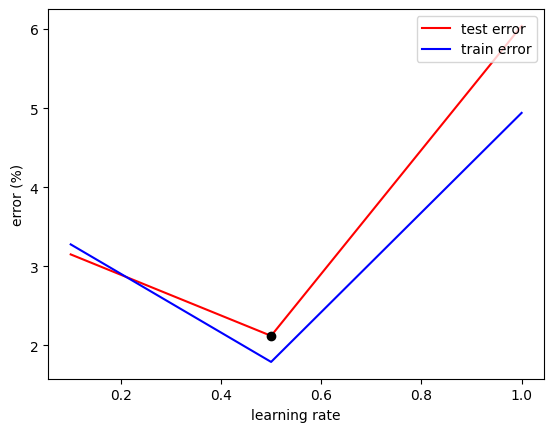

<Figure size 640x480 with 0 Axes>

In [92]:
plt.xlabel("learning rate")
plt.ylabel("error (%)")
plt.plot(learning_rates, test_err_per_lr, color='red')
plt.plot(best_relu_lr, test_err_per_lr[best_relu_idx], 'ok', label='_nolegend_')
plt.plot(learning_rates, train_err_per_lr, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

## Change the number of MLP hidden layers
We will check how the number of hidden layers affects the model's performance. 

Similar to the exploration with different learning rates, you will see how the depth of the network `nLayers` affects its performance, first for a sigmoid network. 

Your code should supports multiple hidden layers (note the new nLayers argument). Each hidden layer should have nHiddens neurons.    
Hint: since now we might have more than one hidden layer, we can use a for loop over `nLayers` to add every layer (each intermediate `Affine` layer has `nHiddens` as both input and output)

Fill the missing code below to populate `train_err_per_depth` and `test_err_per_depth` accordingly

In [93]:
nInputs = train_images.shape[1] # 784-dimension 
nOutputs = 10 # Output dimension
nHiddens = 64 # Number of neurons in the hidden layer

edf.learning_rate = best_sigmoid_lr
# edf.learning_rate = 0.5
num_epochs = 5
batch_size = 64
num_layers = [2, 4, 6]

train_err_per_depth = []
test_err_per_depth = []

for nLayers in num_layers: # nLayers: number of hidden layers
    print ("Num Layers {}".format(nLayers))
    np.random.seed(1234)
    edf.clear_compgraph()
    
    x_node = edf.Input()
    y_node = edf.Input()
    param_first = edf.AffineParams(nInputs, nHiddens)
    h = edf.Sigmoid(edf.Affine(param_first, x_node))

    # TO-DO: add code below
    # for i in range(nLayers-1):
    #     ...
    #     ...
    # prob_node = ...
    # loss_node = ...
    for i in range(nLayers-1):
        #add one layer
        param = edf.AffineParams(nHiddens, nHiddens)
        h = edf.Sigmoid(edf.Affine(param, h))
    prob_node = edf.Softmax(edf.Affine(edf.AffineParams(nHiddens, nOutputs), h))
    loss_node = edf.CrossEntropyLoss(prob_node, y_node)
    train_err_log, test_err_log = train_and_test(num_epochs, batch_size, x_node, y_node, prob_node, loss_node)
    train_err_per_depth.append(train_err_log)
    test_err_per_depth.append(test_err_log)
    
train_err_per_depth = np.min(train_err_per_depth, axis=1)
test_err_per_depth = np.min(test_err_per_depth, axis=1)
best_sigmoid_idx = np.argmin(test_err_per_depth)
best_sigmoid_depth = num_layers[best_sigmoid_idx]


Num Layers 2
Epoch: 1/5 (learning rate: 1.0)
	 Batch 400/937
	 Batch 800/937
	 Training Error 15.71 %
	 Test Error 8.37 %
Epoch: 2/5 (learning rate: 1.0)
	 Batch 400/937
	 Batch 800/937
	 Training Error 5.36 %
	 Test Error 6.06 %
Epoch: 3/5 (learning rate: 1.0)
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.77 %
	 Test Error 4.58 %
Epoch: 4/5 (learning rate: 1.0)
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.93 %
	 Test Error 3.66 %
Epoch: 5/5 (learning rate: 1.0)
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.40 %
	 Test Error 3.22 %
Num Layers 4
Epoch: 1/5 (learning rate: 1.0)
	 Batch 400/937
	 Batch 800/937
	 Training Error 85.73 %
	 Test Error 67.00 %
Epoch: 2/5 (learning rate: 1.0)
	 Batch 400/937
	 Batch 800/937
	 Training Error 31.14 %
	 Test Error 17.53 %
Epoch: 3/5 (learning rate: 1.0)
	 Batch 400/937
	 Batch 800/937
	 Training Error 8.18 %
	 Test Error 8.24 %
Epoch: 4/5 (learning rate: 1.0)
	 Batch 400/937
	 Batch 800/937
	 Training Error 5.37 %
	 Test Error 5.30

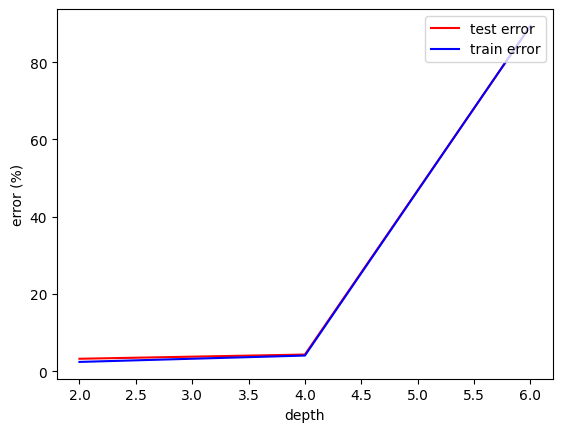

<Figure size 640x480 with 0 Axes>

In [94]:
plt.xlabel("depth")
plt.ylabel("error (%)")
plt.plot(num_layers, test_err_per_depth, color='red')
plt.plot(num_layers, train_err_per_depth, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

Now repeat the experiment above for a ReLU MLP

In [96]:
nInputs = train_images.shape[1] # 784-dimension 
nOutputs = 10 # Output dimension
nHiddens = 64 # Number of neurons in the hidden layer

edf.learning_rate = best_relu_lr
# edf.learning_rate = 0.5
num_epochs = 5
batch_size = 64
num_layers = [2, 4, 6]

train_err_per_depth = []
test_err_per_depth = []

for nLayers in num_layers:
    print ("Num Layers {}".format(nLayers))
    np.random.seed(1234)
    
    edf.clear_compgraph()
    x_node = edf.Input()
    y_node = edf.Input()
    param_first = edf.AffineParams(nInputs, nHiddens)
    h = ReLU(edf.Affine(param_first, x_node))

    for i in range(nLayers-1):
        #add one layer
        param = edf.AffineParams(nHiddens, nHiddens)
        h = ReLU(edf.Affine(param, h))
    prob_node = edf.Softmax(edf.Affine(edf.AffineParams(nHiddens, nOutputs), h))
    loss_node = edf.CrossEntropyLoss(prob_node, y_node)
    train_err_log, test_err_log = train_and_test(num_epochs, batch_size, x_node, y_node, prob_node, loss_node)
    train_err_per_depth.append(train_err_log)
    test_err_per_depth.append(test_err_log)
    
train_err_per_depth = np.min(train_err_per_depth, axis=1)
test_err_per_depth = np.min(test_err_per_depth, axis=1)
best_relu_idx = np.argmin(test_err_per_depth)
best_relu_depth = num_layers[best_relu_idx]

Num Layers 2
Epoch: 1/5 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 10.04 %
	 Test Error 7.78 %
Epoch: 2/5 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.32 %
	 Test Error 4.53 %
Epoch: 3/5 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.24 %
	 Test Error 3.67 %
Epoch: 4/5 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.79 %
	 Test Error 2.69 %
Epoch: 5/5 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.27 %
	 Test Error 2.73 %
Num Layers 4
Epoch: 1/5 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 26.16 %
	 Test Error 9.37 %
Epoch: 2/5 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 6.95 %
	 Test Error 8.31 %
Epoch: 3/5 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 5.38 %
	 Test Error 5.61 %
Epoch: 4/5 (learning rate: 0.5)
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.46 %
	 Test Error 4.75 %


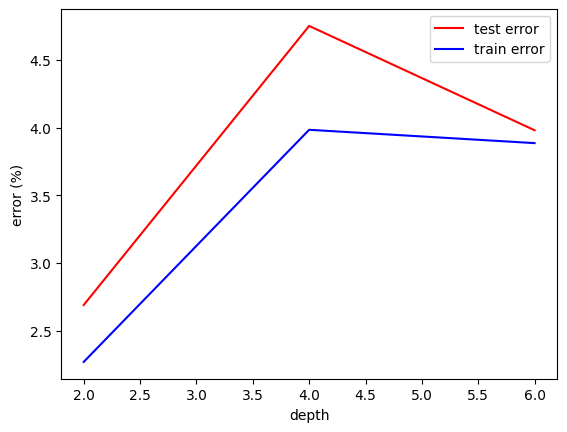

<Figure size 640x480 with 0 Axes>

In [97]:
plt.xlabel("depth")
plt.ylabel("error (%)")
plt.plot(num_layers, test_err_per_depth, color='red')
plt.plot(num_layers, train_err_per_depth, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

## Change the Width of MLP hidden layers
We will check how different hidden dimensions affect the model's performance. 
Fill the missing code below to populate `train_err_per_hidden` and `test_err_per_hidden` accordingly

You can reuse everything you coded above. 


In [ ]:
edf.learning_rate = best_sigmoid_lr
num_epochs = 5
batch_size = 64
num_hidden = [32, 64, 128]

nLayers = best_sigmoid_depth

train_err_per_hidden = []
test_err_per_hidden = []

for nHiddens in num_hidden:
    print ("Hidden Dimension {}".format(nHiddens))
    np.random.seed(1234)
    edf.clear_compgraph()
    
    x_node = edf.Input()
    y_node = edf.Input()
    param_first = edf.AffineParams(nInputs, nHiddens)
    h = edf.Sigmoid(edf.Affine(param_first, x_node))

    # TO-DO: add code below
    # for i in range(nLayers-1):
    #     ...
    #     ...
    # prob_node = ...
    # loss_node = ...
    
    # train_err_per_hidden
    # test_err_per_hidden


In [ ]:
plt.xlabel("hidden dimension")
plt.ylabel("error (%)")
plt.plot(num_hidden, test_err_per_hidden, color='red')
plt.plot(num_hidden, train_err_per_hidden, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

Again, Replace `Sigmoid` with `ReLU`

In [ ]:
edf.learning_rate = best_relu_lr
num_epochs = 5
batch_size = 64
num_hidden = [32, 64, 128]

nLayers = best_relu_depth

train_err_per_hidden = []
test_err_per_hidden = []

for nHiddens in num_hidden:
    print ("Hidden Dimension {}".format(nHiddens))
    np.random.seed(1234)
    edf.clear_compgraph()
    
    x_node = edf.Input()
    y_node = edf.Input()
    param_first = edf.AffineParams(nInputs, nHiddens)
    h = ReLU(edf.Affine(param_first, x_node))

    # TO-DO: add code below
    # for i in range(nLayers-1):
    #     ...
    #     ...
    # prob_node = ...
    # loss_node = ...
    
    # train_err_per_hidden
    # test_err_per_hidden
    

In [ ]:
plt.xlabel("hidden dimension")
plt.ylabel("error (%)")
plt.plot(num_hidden, test_err_per_hidden, color='red')
plt.plot(num_hidden, train_err_per_hidden, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

### Inline Question 2:
Assume a model's train error keeps decreasing, but the test error increases when hidden dimension is too large (as shown below), what might be the reason?

**Your answer:** *Overfitting*
